In [1]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('font', size=15)
mpl.rc('figure', figsize=(8, 5))

import numpy as np
import scipy.signal as sig
import keras

from keras.layers import Input, Dense, Activation, Dropout
from keras.models import Model
from keras.models import load_model
from keras import regularizers
from keras.initializers import glorot_normal, glorot_uniform
from keras.optimizers import Adam

from mpl_toolkits.basemap import Basemap
from matplotlib.path import Path



Using TensorFlow backend.


## Load data and Preprocessing

In [2]:
# fix random seed for reproducibility
np.random.seed(7)

# Load data and exclude nan value
data = np.genfromtxt('H1O1O2_GPR_earthquakes.txt')
#data1 = np.genfromtxt('Hanfordtestdata.txt')
print (len(data))

2105


In [3]:
#####maybe if we cut out the  P waves we can get better results## 
#going to chooose 6000 

#eqgpstime = data[:,0]
#peakgpstime = data[:,24]
#arrivaltime = np.subtract(peakgpstime,eqgpstime)
#distance = data[:,12]
#Velocity = np.divide(distance, arrivaltime)
#pwaveomit = 6000
#Velocity1 = Velocity[Velocity<6000]
#data = data[Velocity<6000]
#print (len(data))

1695


In [4]:

#eq_lat2 = data[:,10]
#eq_lon2 = data[:,11]
#map1 = Basemap(projection='aeqd', lon_0 = 10, lat_0 = 50, resolution='h')
#lats = eq_lat2  #[:100]                                                                                                        \
                                                                                                                                
#lons = eq_lon2
#x, y = map1(lons, lats)
#locations = np.c_[x, y]
#polygons = [Path(p.boundary) for p in map1.landpolygons]
#result = np.zeros(len(locations), dtype=bool)
#for polygon in polygons:
#    result += np.array(polygon.contains_points(locations))

###eq_lat1=lats[result]
###eq_lon1=lons[result]
print (len(data))
###print (result)
#data =data[result]
#print (len(data))



1695


In [5]:
# Extract X and y and divide into train, val, and test set
#X = data[:, [2, 11, 12, 13, 14, 15]] #iris   #side note nikils has log10distnace maybe we should try that
X = data[:, [1, 10, 11, 12, 13, 14]] #L10102, H10102, V10102
#side note nikils has log10distnace maybe we should try that
#X = data1[:, [0, 1, 2, 3, 4, 5]] #from Handford test data with log10 distance

#z = np.log10(data[:, 18]) #iris 
Z = np.log10(data[:, 25]) #L10102, H10102, V10102

#Have to redifine velocity parameters so same shape after above cuts
eqgpstime = data[:,0]
peakgpstime = data[:,24]
arrivaltime = np.subtract(peakgpstime,eqgpstime)
distance = data[:,12]
Velocity = np.divide(distance, arrivaltime)





#y =np.subtract((data[:,24 ]),(data[:, 0]))
y = Velocity
#y = np.log10(y)
#print(y)


# Data preprocessing
# Exclude bad data
#y = np.log10(1e-6)
#mask = Z > -6.0 

#y = y[mask]
#X = X[mask]



print(y.shape)

# Normalizing
X -= np.mean(X, axis=0) #these standard deviations need to be changed if im not doing log?
X /= np.std(X, axis=0)

mean_y = np.mean(y, axis=0)
stdv_y = np.std(y, axis=0)
y = (y-mean_y)/stdv_y

# Shuffle and divide into train and val set
mask = np.random.permutation(X.shape[0]) #(does this work with seed)
X = X[mask]
y = y[mask]

tfrac = int(0.8*y.size) 
X_train = X[:tfrac]
y_train = y[:tfrac]
X_val = X[tfrac:]
y_val = y[tfrac:]

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_val shape: {}'.format(X_val.shape))
print('y_val shape: {}'.format(y_val.shape))


(380,)
X_train shape: (304, 6)
y_train shape: (304,)
X_val shape: (76, 6)
y_val shape: (76,)


## Create a DENSE network

In [6]:
def QuakeNet(input_shape, lr=1e-3, reg=0.00, dropout=0.5):
      #orig (input_shape, lr=1e-3, reg=0.00, dropout=0.0)
    X_input = Input(input_shape)
    
    X = Dense(64, kernel_regularizer=regularizers.l2(reg),
              activation='relu')(X_input)   
   # X = Dense(64, kernel_regularizer=regularizers.l2(reg),
     #         activation='relu')(X)   
    #X = Dense(64, kernel_regularizer=regularizers.l2(reg),
    #          activation='relu')(X)
    X = Dense(64, kernel_regularizer=regularizers.l2(reg),
              activation='relu')(X)
    X = Dense(2, kernel_regularizer=regularizers.l2(reg),
              activation='relu')(X)
    X = Dropout(rate=dropout)(X)
    X = Dense(1, kernel_regularizer=regularizers.l2(reg))(X)

    model = Model(inputs=X_input, outputs=X, name='QuakeNet')
    model.compile(optimizer=Adam(lr=lr), loss='mse')
    
    return model

In [7]:
input_shape = (X_train.shape[1], )
model = QuakeNet(input_shape=input_shape)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 6)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                448       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
_________________________________________________________________
dropout_1 (Dropout)          (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 3         
Total params: 2,597
Trainable params: 2,597
Non-trainable params: 0
_________________________________________________________________


## Train

In [8]:
stats = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_val, y_val))

Train on 304 samples, validate on 76 samples
Epoch 1/150
304/304 [==============================] - 0s 1ms/step - loss: 1.0263 - val_loss: 0.9025
Epoch 2/150
304/304 [==============================] - 0s 44us/step - loss: 1.0121 - val_loss: 0.9246
Epoch 3/150
304/304 [==============================] - 0s 53us/step - loss: 1.0010 - val_loss: 0.9181
Epoch 4/150
304/304 [==============================] - 0s 47us/step - loss: 0.9989 - val_loss: 0.9203
Epoch 5/150
304/304 [==============================] - 0s 48us/step - loss: 0.9971 - val_loss: 0.9270
Epoch 6/150
304/304 [==============================] - 0s 51us/step - loss: 0.9951 - val_loss: 0.9172
Epoch 7/150
304/304 [==============================] - 0s 54us/step - loss: 1.0040 - val_loss: 0.9204
Epoch 8/150
304/304 [==============================] - 0s 48us/step - loss: 1.0025 - val_loss: 0.9092
Epoch 9/150
304/304 [==============================] - 0s 55us/step - loss: 0.9993 - val_loss: 0.9260
Epoch 10/150
304/304 [================

## Predict

In [9]:
model.save('hlvavat1.hdf5')

model = load_model('hlvavat1.hdf5')

In [10]:
y_pred = model.predict(X_val) # X_val could be new data too?
# Inverse-normalize
y_val = y_val*stdv_y + mean_y
y_pred = y_pred*stdv_y + mean_y

(76,)
(76,)


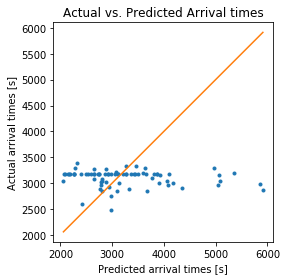

In [11]:
print(y_val.shape)
y_pred = y_pred.flatten()

print(y_pred.shape)
fig, ax = plt.subplots()

y_val = abs(y_val)
y_pred = abs(y_pred)

v_min = min(np.min(y_val), np.min(y_pred))
v_max = max(np.max(y_val), np.max(y_pred))
x = np.linspace(v_min, v_max, 1000)


ax.plot(y_val, y_pred, '.')
ax.plot(x, x)
ax.set(title= 'Actual vs. Predicted Arrival times', xlabel='Predicted arrival times [s]', ylabel='Actual arrival times [s]')

fig.tight_layout()
ax.set(adjustable='box', aspect='equal')
plt.savefig('HLVATtest.png', dpi =300,bbox_inches='tight')
#plt.savefig('VIRATtest.png', dpi =300,bbox_inches='tight')
plt.show()

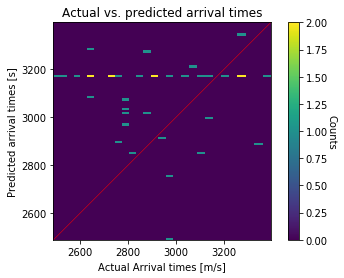

In [12]:
x = np.linspace(v_min, v_max, 1000)
fig2, ax, = plt.subplots()
x_bins = np.logspace(np.log10(y_val.min()), np.log10(y_val.max()),np.sqrt(10000)) #12279
y_bins = np.logspace(np.log10(y_pred.min()), np.log10(y_pred.max()),np.sqrt(10000))
H, xedges, yedges = np.histogram2d(y_val, y_pred, bins=[x_bins,y_bins])
#ax2 = fig.add_subplot(212)
h = ax.pcolormesh(xedges, yedges, H.T)
#ax.set_aspect('equal')
#ax.set(adjustable='box-forced', aspect='equal')
#a2.imshow(img, origin='lower', extent=extent, aspect='auto')
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.axis([yedges.min(),yedges.max(),yedges.min(),yedges.max()])
ax.set(ylabel='Predicted arrival times [s]', xlabel='Actual Arrival times [m/s]',title = 'Actual vs. predicted arrival times')




cbar = plt.colorbar(h, ax=ax)
ax.plot(x, x, c='r',linewidth=.5)
#ax.set_ylim([0, 10e-2])
#ax.set_xlim([0, 10e-2])
#ax.set_aspect('equal')
#cbar =plt.colorbar()
#cbar.ax.set_ylabel('Counts')
cbar.set_label('Counts', rotation=270,labelpad=9)

fig.tight_layout()
ax.set(adjustable='box', aspect='equal')
plt.savefig('HLVATdensitytest.png', dpi =300,bbox_inches='tight')
#plt.savefig('VIRATdensitytest.png', dpi =300,bbox_inches='tight')
plt.show()

(76,)
0.008114851524446917
0.5365235381002298
0.20304920894887613


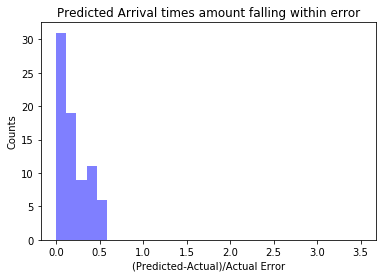

In [13]:
z = np.array(abs((y_val -y_pred)/y_val))

#print(z)
print(z.shape)
print(np.min(z))
print(np.max(z))
print (np.average(z))
#x_bins = np.logspace(np.log10(antiy_val.min()), np.log10(antiy_val.max()),np.sqrt(12279))
#y_bins = np.logspace(np.log10(antiy_pred.min()), np.log10(antiy_pred.max()),np.sqrt(12279))
plt.hist(z, bins=30,range =[0,3.5], facecolor='blue', alpha=0.5)
plt.xlabel('(Predicted-Actual)/Actual Error')
plt.ylabel('Counts')
plt.title('Predicted Arrival times amount falling within error')
plt.savefig('HLVAThisttest.png', dpi =300,bbox_inches='tight')
#plt.savefig('VIRAThisttest.png', dpi =300,bbox_inches='tight')
plt.show()


In [14]:
#to check if target is uniformly distributed (input data not predicted) 

#weights = (np.ones_like(y_pred)/float(len(y_pred)))*100
#bins =100
#plt.hist(y, bins=bins, facecolor='blue', alpha=0.5)
#plt.xlabel('EQ ground velocities [meters/seconds]')